In [27]:
"""
This notebook generates the frequency and prom:enhD ratio plots in for TF-MoDISco profile (Fig. 2D)
For example track and DeepSHAP plots, please see the example tracks directory.
"""

'\nThis notebook generates the frequency and prom:enhD ratio plots in for TF-MoDISco profile (Fig. 2D)\nFor example track and DeepSHAP plots, please see the example tracks directory.\n'

In [4]:
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

URL = "https://zenodo.org/records/10597358/files"
TAR = "tfmodisco_results.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -cvzf {SCRATCH}/{TAR}")

wget https://zenodo.org/records/10597358/files/tfmodisco_results.tar.gz -P /Users/adamhe/github/scratch
tar -cvzf /Users/adamhe/github/scratch/tfmodisco_results.tar.gz


In [15]:
# LOAD DATA

# Get promoter and enhancer indices
idx = np.load(Path(SCRATCH, "tfmodisco_results/all_enh_prom_idx.npz"), allow_pickle=True)
prom_idx = idx["prom_idx"]
enh_idx = idx["enh_idx"]
# Read in all bed file
all_bed = pd.read_csv(Path(SCRATCH, "tfmodisco_results/merged_windows_all.bed.gz"), sep="\t", header=None)

# Load the modisco results
modisco = h5py.File(os.path.join(SCRATCH, "tfmodisco_results/mean_across_folds_all_profile_modisco.h5"), "r")

In [19]:
# Manually annotate modisco hits by likely motif

motifs = [
    "CA (Inr)",
    "NFY",
    "TATA",
    "TA (Inr)",
    "ETS",
    "DPR",
    "NFY",
    "DPR",
    "DPR",
    "DPR",
    "DPR",
    "DPR",
    "IRF",
    "DPR",
    "TATA",
    "CREB",
    "NRF1",
    "YY1",
    "TGT (Inr)",
    "CpG",
    "POU",
    "TFEC",
    "IRF",
    "JUN",
    "TA (Inr)",
    "CGA (Inr)",
    "CTCF",
    "DPR",
    "IRF",
    "ZBTB33",
    "CA (Inr)",
    "ETS",
    "TBP",
    "ETS",
    "ETS",
    "CA (Inr)",
    "CA (Inr)",
    "POU",
    "TCT",
    "CA (Inr)",
    "GA (Inr)",
    "YY1",
    "Runt",
    "TBP",
    "???",
    "TBP",
    "GA (Inr)",
    "CA (Inr)",
    "CA (Inr)",
    "CA (Inr)",
    "SP/KLF",
    "???",
    "???",
    "SP/KLF",
    "???",
    "???",
    "TBP",
    "NRF1",
    "NRF1",
    "YY1",
    "NFY",
]

In [21]:
# Get counts per motif (w/ and w/o counting multiplicity per element)

modisco_n = len(modisco["pos_patterns"])

unique_counts = pd.DataFrame(
    {
        "all": [
            len(set(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"]))
            for i in range(modisco_n)
        ],
        "prom": [
            len(set(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"]).intersection(set(prom_idx)))
            for i in range(modisco_n)
        ],
        "enhD": [
            len(set(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"]).intersection(set(enh_idx)))
            for i in range(modisco_n)
        ],
    }
)

counts = pd.DataFrame(
    {
        "all": [
            len(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"])
            for i in range(modisco_n)
        ],
        "prom": [
            pd.Series(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"][:]).isin(prom_idx).sum()
            for i in range(modisco_n)
        ],
        "enhD": [
            pd.Series(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"][:]).isin(enh_idx).sum()
            for i in range(modisco_n)
        ],
    }
)

In [24]:
# Calculate motif frequency and probability of an element containing at least one motif

unique_frequency = unique_counts.divide(
    [len(set(all_bed)), len(set(prom_idx)) - 1, len(set(enh_idx)) - 1], axis=1
)
frequency = counts.divide(
    [len(set(all_bed)), len(set(prom_idx)) - 1, len(set(enh_idx)) - 1], axis=1
)

# Group modisco frequencies by motif

frequency.index = motifs
grouped_frequency = frequency.groupby(frequency.index).sum().sort_values("all", ascending=False)
grouped_unique_frequency = unique_frequency.groupby(frequency.index).sum().sort_values("all", ascending=False)
grouped_unique_counts = unique_counts.groupby(motifs).sum().sort_values("all", ascending=False)
grouped_counts = counts.groupby(motifs).sum().sort_values("all", ascending=False)

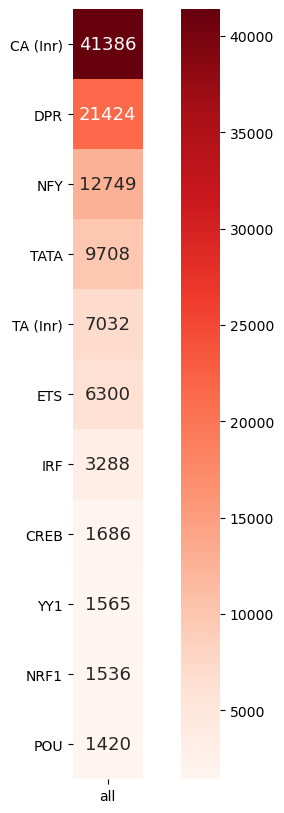

In [26]:
# Plot motif frequency

fig = plt.figure(figsize=(10, 10))
sns.heatmap(
    pd.DataFrame(grouped_counts["all"]).iloc[:11],
    annot=True,
    annot_kws={"size": 13},
    cmap="Reds",
    fmt="g",
    square=True,
    #cbar=False,
    #norm=colors.TwoSlopeNorm(0)
)
plt.yticks(rotation=0) 
plt.savefig("img/modisco_profile_frequency_plot.pdf")

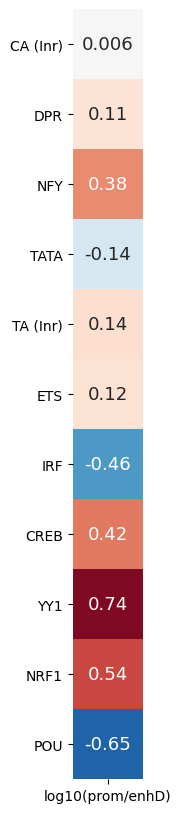

In [25]:
# Plot log10(prom/enhD)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(
    pd.DataFrame(np.log10(grouped_frequency.prom / grouped_frequency.enhD), columns=["log10(prom/enhD)"])[:11],
    annot=True,
    annot_kws={"size": 13},
    fmt=".2",
    square=True,
    cbar=False,
    cmap="RdBu_r",
    norm=colors.Normalize(-0.8, 0.8)
)
plt.yticks(rotation=0) 
plt.savefig("img/modisco_profile_prom2enh_plot.pdf")